# Project – Finite Element Method for a 2D Poisson Problem

## 📌 Overview
This project implements the **P1 finite element method (FEM)** in Python for solving a 2D elliptic partial differential equation (Poisson problem) on the unit square.  
The workflow covers mesh generation, weak formulation, assembly of stiffness and load matrices, imposition of boundary conditions, and visualization of the numerical solution.

---

## 🧮 Problem Formulation
We solve the Poisson equation on $\Omega = (0,1)^2$:

$$
- \Delta u(x,y) = f(x,y), \quad (x,y) \in \Omega,
$$

with homogeneous Dirichlet boundary conditions:

$$
u(x,y) = 0, \quad (x,y) \in \partial \Omega.
$$

Here:
- $f(x,y)$ is the forcing term,  
- $u(x,y)$ is the unknown solution.  

---

## ⚙️ Method
1. **Weak formulation**  
   Multiply by a test function $v$ and integrate by parts:

   $$
   \int_\Omega \nabla u \cdot \nabla v \, dxdy
   = \int_\Omega f v \, dxdy.
   $$

2. **Finite Element discretization**  
   - Partition $\Omega$ into triangular elements.  
   - Use piecewise linear basis functions $\{\phi_i\}$ (hat functions).  
   - Approximate $u(x,y) \approx \sum_i U_i \phi_i(x,y)$.

3. **Matrix assembly**  
   - **Element stiffness matrix:**  
     $$
     A^T_{ij} = \int_T \nabla \phi_i \cdot \nabla \phi_j \, dxdy
     $$
   - **Element load vector:**  
     $$
     L^T_i = \int_T f \, \phi_i \, dxdy
     $$
   - Global system:  
     $$
     A U = L
     $$

4. **Boundary conditions**  
   Dirichlet BCs are enforced by modifying rows/columns in the global matrix.

5. **Numerical solution**  
   Solve the sparse linear system for the coefficient vector $U$.

---

## 📊 Results
- Verified the implementation with a manufactured exact solution (e.g., $u(x,y) = \sin(\pi x)\sin(\pi y)$).  
- Computed numerical errors and confirmed convergence as the mesh is refined.  
- Produced 2D visualizations:
  - Surface plots of the numerical solution $u(x,y)$.  
  - Error distribution across the domain.  

---

## 📂 Files
- `pdes_ex7.1.ipynb` → Jupyter notebook with FEM implementation, assembly, solver, and plots.  

---

## ✅ Key Takeaways
- Built a complete FEM solver for the 2D Poisson equation from scratch.  
- Learned how to construct element matrices on triangles and assemble them globally.  
- Verified error reduction with mesh refinement.  
- Gained experience in handling sparse systems and visualizing PDE solutions in 2D.


In [5]:
# import numpy as np

def lagrange_basis(p, xi_quad):
    """
    Build nodal Lagrange shape functions and their derivatives at quadrature points
    by expressing them in the Legendre basis and inverting the Vandermonde system.
    """
    # 1) define the p+1 nodal points on [-1,1]
    xi_nodes = np.linspace(-1, 1, p+1)              # shape (p+1,)

    # 2) build the (p+1)x(p+1) Vandermonde matrix V_{jk}=P_k(xi_j)
    #    where P_k are the eval_Legendre basis functions
    V = eval_Legendre(xi_nodes, p+1)                # shape (p+1, p+1)
    invV = np.linalg.inv(V)

    # 3) evaluate Legendre basis at your quadrature points
    P_quad  = eval_Legendre(xi_quad,    p+1)        # shape (p+1, n_q)
    dP_quad = eval_grad_Legendre(xi_quad, p+1)      # shape (p+1, n_q)

    # 4) transform into nodal Lagrzange basis:
    #    row i of invV @ P_quad is [ℓ_i(ξ_m)]_m
    shape_funcs_ref     = invV @ P_quad             # shape (p+1, n_q)
    der_shape_funcs_ref = invV @ dP_quad            # shape (p+1, n_q)

    return shape_funcs_ref, der_shape_funcs_ref

def solveFEM1D(f, p, N, a, b):
    # 1) element size and mesh nodes
    h      = (b - a)/N
    x_vals = [a + i*h for i in range(N+1)]   # N elements, N+1 nodes

    # 2) reference‐element quadrature + basis
    xi, w                   = gaussLegendre(p+1)          # on [-1,1]
    shape_funcs_ref         = eval_Legendre(xi, p+1)      # φ̂_i(ξ_m)
    der_shape_funcs_ref     = eval_grad_Legendre(xi, p+1) # φ̂_i′(ξ_m)
#     shape_funcs_ref, der_shape_funcs_ref = lagrange_basis(p, xi)
    
    
    # 3) allocate global system
    Np     = N*p + 1
    A      = np.zeros((Np, Np))
    b_vec  = np.zeros(Np)

    # 4) element‐by‐element assembly
    for element_number in range(N):
        xl, xr = x_vals[element_number], x_vals[element_number+1]
        J      = (xr - xl)/2
        x_phys = [(xl + xr)/2 + J*ξ for ξ in xi]
        f_phys = f(np.array(x_phys))

        glob_e_indices = [element_number*p + k for k in range(p+1)]

        # 4a) build and scatter local stiffness
        A_local = np.zeros((p+1, p+1))
        for i_loc in range(p+1):
            for j_loc in range(p+1):
                A_local[i_loc, j_loc] = np.sum(
                    w
                    * der_shape_funcs_ref[i_loc, :] 
                    * der_shape_funcs_ref[j_loc, :] 
                    / J
                )
        for i_loc in range(p+1):
            for j_loc in range(p+1):
                A[glob_e_indices[i_loc], glob_e_indices[j_loc]] += A_local[i_loc, j_loc]

        # 4b) build and scatter local load
        b_local = np.zeros(p+1)
        for i_loc in range(p+1):
            b_local[i_loc] = np.sum(
                w 
                * shape_funcs_ref[i_loc, :] 
                * f_phys 
                * J
            )
            b_vec[glob_e_indices[i_loc]] += b_local[i_loc]

    # 5) impose Dirichlet u(a)=u(b)=0
    for idx in (0, Np-1):
        A[idx, :]   = 0
        A[:, idx]   = 0
        A[idx, idx] = 1
        b_vec[idx]  = 0

    # 6) solve and return
    u = np.linalg.solve(A, b_vec)
    return x_vals, u


# Testing



 
 [[ 1.          1.          1.        ]
 [-0.77459667  0.          0.77459667]
 [ 0.4        -0.5         0.4       ]
 [ 0.         -0.          0.        ]] 
 


 
 [[ 1.          1.          1.        ]
 [-0.77459667  0.          0.77459667]
 [ 0.4        -0.5         0.4       ]
 [ 0.         -0.          0.        ]] 
 


 
 [[ 1.          1.          1.        ]
 [-0.77459667  0.          0.77459667]
 [ 0.4        -0.5         0.4       ]
 [ 0.         -0.          0.        ]] 
 


 
 [[ 1.          1.          1.        ]
 [-0.77459667  0.          0.77459667]
 [ 0.4        -0.5         0.4       ]
 [ 0.         -0.          0.        ]] 
 


 
 [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [-8.61136312e-01 -3.39981044e-01  3.39981044e-01  8.61136312e-01]
 [ 6.12333621e-01 -3.26619335e-01 -3.26619335e-01  6.12333621e-01]
 [-3.04746985e-01  4.11728000e-01 -4.11728000e-01  3.04746985e-01]
 [-1.66533454e-16  5.55111512e-17  5.55111512e-17 -1.66533454e-16]] 

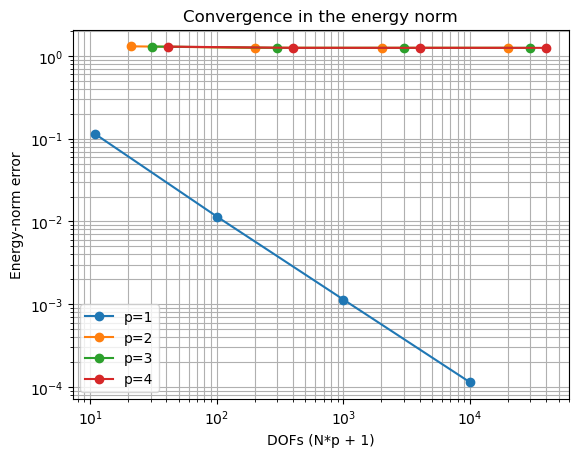

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes solveFEM1D, gaussLegendre, eval_grad_Legendre are already defined

def compute_energy_error(x_vals, u_h, p, N, xi, w, der_shape_funcs_ref):
    """
    Compute the energy-norm error ||u - u_h||_E for u(x)=sin(x), u'(x)=cos(x).
    xi, w: reference quadrature points and weights
    der_shape_funcs_ref: eval_grad_Legendre(xi, p+1)
    """
    h      = x_vals[1] - x_vals[0]
    J      = h/2
    error_sq = 0.0

    for e in range(N):
        xl, xr = x_vals[e], x_vals[e+1]
        glob_e_indices   = [e*p + k for k in range(p+1)]
        u_loc  = u_h[glob_e_indices]

        # map quad points to physical
        x_phys = (xl + xr)/2 + J*xi
        u_ex_pr = np.cos(x_phys)  # exact derivative

        # approximate u_h' at quadrature points
        # u_h'(x) = sum_i u_loc[i] * (hat_phi_i'(xi)/J)
        u_h_pr = (u_loc[:, None] * der_shape_funcs_ref).sum(axis=0) / J

        # accumulate ∫(u_ex' - u_h')^2 dx ≈ Σ w * (error)^2 * J
        error_sq += np.sum(w * (u_ex_pr - u_h_pr)**2 * J)

    return np.sqrt(error_sq)

# --- convergence test ---
p_list = [1, 2, 3, 4]
N_list = [10, 100,1000, 10000]

plt.figure()
for p in p_list:
    ndofs = []
    errs  = []
    # prepare reference data for this p
    xi, w = gaussLegendre(p+1)
    der   = eval_grad_Legendre(xi, p+1)

    for N in N_list:
        x_vals, u_h = solveFEM1D(np.sin, p, N, 0.0, np.pi)
        err = compute_energy_error(x_vals, u_h, p, N, xi, w, der)
        ndofs.append(N * p + 1)
        errs.append(err)

    plt.loglog(ndofs, errs, '-o', label=f'p={p}')

plt.xlabel('DOFs (N*p + 1)')
plt.ylabel('Energy-norm error')
plt.title('Convergence in the energy norm')
plt.legend()
plt.grid(True, which='both')
plt.show()


# Helper Functions

In [3]:
import numpy as np

def eval_Legendre(x, n): # shape functions 


    # Calculates the first n basis functions on [-1,1];
    # we assume implicitly that the vector x is a row vector
    
    U = np.zeros((n, len(x)))
    U[0, :] = (1 - x) / 2
    U[1, :] = (1 + x) / 2
    
    if n > 2:
        P = legtable(x, n) 
        print("\n \n",P,"\n \n")
        for i in range(3, n + 1):
            ip = i - 2
            U[i - 1, :] = np.sqrt((2 * i - 3) / 2) * (P[ip + 2, :] - P[ip, :]) / (2 * ip + 1)
    
    return U

def legtable(x, m): # builds legendre polynomials at points x, m for each x
    
    # input:  row vector x \subset (-1,1) of points
    #         m the maximal order of the Legendre polynomials
    # output: a matrix P=P(m+1,length(x)) containing the values of the
    #         Legendre polynomials at the points x
    
    l = len(x)
    P = np.ones((m + 1, l))
    P[1, :] = x
    
    for i in range(2, m + 1):
        P[i, :] = ((2 * i - 1) * x * P[i - 1, :] - (i - 1) * P[i - 2, :]) / i
    
    return P

# --------------------------------------------

def eval_grad_Legendre(x, n):
    # Calculates the derivatives of the first n trial functions on [-1,1];
    # we assume implicitly that the vector x is a row vector
    
    U = np.zeros((n, len(x)))
    U[0, :] = -1 / 2 * np.ones_like(x)
    U[1, :] = 1 / 2 * np.ones_like(x)
    
    if n > 2:
        P = legtable(x, n)
        for i in range(3, n + 1):
            ip = i - 2
            U[i - 1, :] = np.sqrt((2 * i - 3) / 2) * P[ip + 1, :]
    
    return U

# --------------------------------------------


def gaussLegendre(n):
    # Gauss Legendre Quadrature Weights
    x = np.zeros(n)
    w = np.zeros(n)

    # The roots of the Legendre polynomial P_n are symmetrical in [-1,1]
    for i in range(1, (n + 1) // 2 + 1):
        # first approximation of i-th root
        z = np.cos(np.pi * (i - 0.25) / (n + 0.5))

        # Newton's method
        zOld = np.inf
        while abs(z - zOld) > 1e-12:
            # calculate p1 = P_n(z) by the recursion formula
            p1 = 1
            p2 = 0
            for j in range(1, n + 1):
                p3 = p2
                p2 = p1
                p1 = ((2 * j - 1) * z * p2 - (j - 1) * p3) / j

            # calculate pp = P'_n(z) using p2 = P_{n-1}(z)
            pp = n * (z * p1 - p2) / (z * z - 1)

            # update z
            zOld = z
            z = z - p1 / pp

        # set root and its symmetric counterpart
        x[i - 1] = -z
        x[n - i] = z

        # calculate weight and set symmetric counterpart
        w[i - 1] = 2 / ((1 - z ** 2) * pp ** 2)
        w[n - i] = w[i - 1]

    return x, w